In [ ]:
r"""
August 13, 2025
 * Xiaoming Zheng
 * Akram Moustafa
 * Department of Mathematics
 * Central Michigan University
 * Mount Pleasant, MI 48859
 *
   Solve Perturbation Of Anistropic Boussinest Equation
   from the paper
Adhikari, D., Ben Said, O., Pandey, U.R., Wu Jiahong Stability and large-time behavior for the 2D Boussineq system with horizontal dissipation and vertical thermal diffusion. Nonlinear Differ. Equ. Appl. 29, 42 (2022). https://doi.org/10.1007/s00030-022-00773-4

Purpose: finding solution
   u = (u1 u2) and theta satisfying Equation: (1.10)

   D_t u  + (u\cdot \nabla) u = -\nabla p + \nu D_11 u + \theta e_2
   D_t theta + u\cdot \theta + u_2 = \eta D_22 \theta

This code is using the vorticity-stream function form:
   w = vorticity = D_1 u2 - D_2 u1
   D_t w + u\cdot\nabla w = \nu D_11 w + D_1 \theta
   -\Laplace\psi = w
   u = \nabla\perp\psi = (D_2\psi, -D_1\psi)

Two files are need to run this file which include an input vorticity file and configuration file. Please refer to this link to know how to generate the input vorticity.
"""
from dataclasses import dataclass
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import math
import configparser
from dataclasses import dataclass
import matplotlib.pyplot as plt
import torch
import torch.fft as fft
import os
PI = np.pi
L = 2*PI

class GaussianRF2d(object):

    def __init__(self, s1, s2, L1=2*math.pi, L2=2*math.pi, alpha=2.0, tau=3.0, sigma=None, mean=None, boundary="periodic", device="cpu", dtype=torch.float64):

        self.s1 = s1
        self.s2 = s2

        self.mean = mean

        self.device = device
        self.dtype = dtype

        if sigma is None:
            self.sigma = tau**(0.5*(2*alpha - 2.0))
        else:
            self.sigma = sigma

        const1 = (4*(math.pi**2))/(L1**2)
        const2 = (4*(math.pi**2))/(L2**2)

        freq_list1 = torch.cat((torch.arange(start=0, end=s1//2, step=1),\
                                torch.arange(start=-s1//2, end=0, step=1)), 0)
        k1 = freq_list1.view(-1,1).repeat(1, s2//2 + 1).type(dtype).to(device)

        freq_list2 = torch.arange(start=0, end=s2//2 + 1, step=1)

        k2 = freq_list2.view(1,-1).repeat(s1, 1).type(dtype).to(device)

        self.sqrt_eig = self.sigma*((const1*k1**2 + const2*k2**2 + tau**2)**(-alpha/2.0))
        # self.sqrt_eig = s1*s2*self.sigma*((const1*k1**2 + const2*k2**2 + tau**2)**(-alpha/2.0))
        self.sqrt_eig[0,0] = 0.0

    def sample(self, N, xi=None):
        if xi is None:
            xi  = torch.randn(N, self.s1, self.s2//2 + 1, 2, dtype=self.dtype, device=self.device)

        xi[...,0] = self.sqrt_eig*xi [...,0]
        xi[...,1] = self.sqrt_eig*xi [...,1]
        # print('xi',xi.shape)
        # print("xi_cplx",torch.view_as_complex(xi).shape)
        u = fft.irfft2(torch.view_as_complex(xi), s=(self.s1, self.s2))
        # print('u', u.shape)
        if self.mean is not None:
            u += self.mean

        return u



Mounted at /content/drive


In [ ]:

@dataclass
class Paramss:
    N0: int
    N1: int
    L: float
    dt: float
    METHOD: int
    TMAX: float
    dt_print: float
    dt_norms: float
    eta: float
    nu: float
    WuEpsi: float
    ConvTest: int
    ShenYang: int
    USE_Filter: int
    Filter_alpha: float
    Filter_noiselevel: float
    restart: str
    irestart: int
    A : float

class BoussinesqSolver:
    def __init__(self, params, w_ic = None, th_ic = None):
        self.Params = params
        self.w_ic = w_ic
        self.th_ic = th_ic

    def g1_func(self,t, x, y):
        if self.Params.ConvTest:
            cos_t, sin_t = np.cos(t), np.sin(t)

            sinAx, sinAy = np.sin(self.Params.A * x), np.sin(self.Params.A * y)
            cos2Ax, cos2Ay = np.cos(2 * self.Params.A * x), np.cos(2 * self.Params.A * y)
            sin2Ax, sin2Ay = np.sin(2 * self.Params.A * x), np.sin(2 * self.Params.A * y)

            u1 = cos_t * sinAx**2 * sin2Ay
            u2 = -cos_t * sin2Ax * sinAy**2

            Dtw  = sin_t * (2*self.Params.A*cos2Ax*sinAy**2 + 2*self.Params.A*cos2Ay*sinAx**2)
            D1w  = cos_t * (4*self.Params.A**2*sin2Ax*sinAy**2 - 2*self.Params.A**2*cos2Ay*sin2Ax)
            D2w  = cos_t * (-2*self.Params.A**2*cos2Ax*sin2Ay + 4*self.Params.A**2*sinAx**2*sin2Ay)
            D11w = cos_t * (8*self.Params.A**3*cos2Ax*sinAy**2 - 4*self.Params.A**3*cos2Ay*cos2Ax)
            D1th = cos_t * self.Params.A * sin2Ax * sin2Ay

            return Dtw + u1*D1w + u2*D2w - D1th - self.Params.nu*D11w
        else:
            return np.zeros_like(x, dtype=float)


    def f3_func(self,t, x, y):
            if self.Params.ConvTest:
                cos_t, sin_t = np.cos(t), np.sin(t)

                sinAx, sinAy = np.sin(self.Params.A * x), np.sin(self.Params.A * y)
                cos2Ay, sin2Ay = np.cos(2 * self.Params.A * y), np.sin(2 * self.Params.A * y)
                sin2Ax = np.sin(2 * self.Params.A * x)

                u1 = cos_t * sinAx**2 * sin2Ay
                u2 = -cos_t * sin2Ax * sinAy**2
                th = u1  # redundant but kept for clarity

                Dtth  = -sin_t * sinAx**2 * sin2Ay
                D1th  = cos_t * self.Params.A * sin2Ax * sin2Ay
                D2th  = cos_t * sinAx**2 * 2*self.Params.A * cos2Ay
                D22th = -cos_t * sinAx**2 * 4*self.Params.A**2 * sin2Ay

                return Dtth + u1*D1th + u2*D2th + u2 - self.Params.eta*D22th
            else:
                return np.zeros_like(x, dtype=float)

    def f2_func(self,t, x, y, a):
            if self.Params.ConvTest:
                cos_t, sin_t = np.cos(t), np.sin(t)

                sinAx, sinAy = np.sin(self.Params.A * x), np.sin(self.Params.A * y)
                cos2Ax, sin2Ax = np.cos(2 * self.Params.A * x), np.sin(2 * self.Params.A * x)
                sin2Ay, cos2Ay = np.sin(2 * self.Params.A * y), np.cos(2 * self.Params.A * y)

                u1 = cos_t * sinAx**2 * sin2Ay
                u2 = -cos_t * sin2Ax * sinAy**2
                th = u1
                p  = cos_t * sin2Ax * sin2Ay

                Dtu2  = sin_t * sin2Ax * sinAy**2
                D1u2  = -cos_t * 2*self.Params.A* cos2Ax * sinAy**2
                D2u2  = -cos_t * sin2Ax * self.Params.A * sin2Ay
                D11u2 = cos_t * 4*self.Params.A**2 * sin2Ax * sinAy**2
                D2p   = cos_t * sin2Ax * 2*self.Params.A * cos2Ay

                return Dtu2 + u1*D1u2 + u2*D2u2 + D2p - self.Params.nu*D11u2 - th
            else:
                return np.zeros_like(x, dtype=float)

    def f1_func(self, t, x, y):
            if self.Params.ConvTest:
                cos_t, sin_t = np.cos(t), np.sin(t)

                sinAx, sinAy = np.sin(self.Params.A * x), np.sin(self.Params.A * y)
                cos2Ax, sin2Ax = np.cos(2 * self.Params.A * x), np.sin(2 * self.Params.A * x)
                cos2Ay, sin2Ay = np.cos(2 * self.Params.A * y), np.sin(2 * self.Params.A * y)

                u1 = cos_t * sinAx**2 * sin2Ay
                u2 = -cos_t * sin2Ax * sinAy**2
                p  = cos_t * sin2Ax * sin2Ay

                Dtu1  = -sin_t * sinAx**2 * sin2Ay
                D1u1  = cos_t * self.Params.A * sin2Ax * sin2Ay
                D2u1  = cos_t * sinAx**2 * 2*self.Params.A * cos2Ay
                D11u1 = cos_t * 2*self.Params.A**2 * cos2Ax * sin2Ay
                D1p   = cos_t * 2*self.Params.A * cos2Ax * sin2Ay

                return Dtu1 + u1*D1u1 + u2*D2u1 + D1p - self.Params.nu*D11u1
            else:
                return np.zeros_like(x, dtype=float)

    def winitFunc(self,t, x, y):
            coeff = -np.cos(t) if self.Params.ConvTest else -self.Params.WuEpsi * np.cos(t)

            return coeff * (
                2*self.Params.A*np.cos(2*self.Params.A*x) * np.sin(self.Params.A*y)**2
                + (np.sin(self.Params.A*x)**2) * 2*self.Params.A*np.cos(2*self.Params.A*y)
            )

    def prinitFunc( self,t,  x,  y):
          if(self.Params.ConvTest):
            return np.cos(t)*np.sin(2*self.Params.A*x)*np.sin(2*self.Params.A*y);
          else:
            return self.Params.WuEpsi*np.cos(t)*pow(np.sin(self.Params.A*x),2)*np.sin(2*self.Params.A*y);

    def thinitFunc( self,t,  x,  y):
        # // initial value of theta
            if self.Params.ConvTest:
                return np.cos(t) * (np.sin(self.Params.A * x) ** 2) * np.sin(2 * self.Params.A * y)
            else:
                nX = 4
                tmp0 = 4 * (1.0 + 1.0/4 + 1.0/9 + 1.0/16)
                tmp1 = tmp0 - np.sum([4.0/(i*i) * np.cos(i * x) for i in range(1, nX+1)], axis=0)
                tmp2 = tmp0 - np.sum([4.0/(i*i) * np.cos(i * y) for i in range(1, nX+1)], axis=0)
                  #  return Params.WuEpsi*math.cos(t)* (tmp1 * tmp2 - tmp0*tmp0)
                return self.Params.WuEpsi * np.cos(t) * (tmp1 * tmp2 - tmp0 * tmp0)

    def u1initFunc( self, t,  x,  y):
          if(self.Params.ConvTest):
            return np.cos(t)*pow(np.sin(self.Params.A*x),2)*np.sin(2*self.Params.A*y)
          else:
            return self.Params.WuEpsi*np.cos(t)*pow(np.sin(self.Params.A*x),2)*np.sin(2*self.Params.A*y)

    def u2initFunc( self, t,  x,  y):
          if(self.Params.ConvTest):
            return -np.cos(t)*np.sin(2*self.Params.A*x)*pow(np.sin(self.Params.A*y),2)
          else:
            return -self.Params.WuEpsi*np.cos(t)*np.sin(2*self.Params.A*x)*pow(np.sin(self.Params.A*y),2)

    def AfterNonlinear( self,u1, u2, w, th, time_spec):

            th = np.fft.fftn(th, s=(self.Params.N0, self.Params.N1),axes=(0, 1) ,norm="backward")
            u1 = np.fft.fftn(u1, s=(self.Params.N0, self.Params.N1), axes=(0, 1),norm="backward")
            u2 = np.fft.fftn(u2, s=(self.Params.N0, self.Params.N1), axes=(0, 1),norm="backward")
            w  = np.fft.fftn(w,  s=(self.Params.N0, self.Params.N1), axes=(0, 1),norm="backward")

            return u1, u2, w, th

    def PreNonlinear(self,u1, u2, w, th,N3, N4 , time_spec):

            # Above all, convert input quantities to Physical space:
            u1 = np.fft.ifftn(u1, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
            u2 = np.fft.ifftn(u2, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
            th = np.fft.ifftn(th, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
            w  = np.fft.ifftn(w,  s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real

            # divide them by DIM because FFTW does not perform it:
            # initialize N5 and N6:
            N3[:] = 0.0 + 0.0j
            N4[:] = 0.0 + 0.0j

            return N3, N4,u1, u2, w, th
    def Nonlinear3and4(self, u1, u2, w, th, tmp1,  tmp2,  tmp3, tmp4,   N3, N4, time_spec):

            # computer N3= (u\cdot\nabla)\theta
            # computer N4= (u\cdot\nabla) w
            # Denote z = hat (u\cdot nabla)\theta = hat( div(u*theta) ):
            #          = hat( D_1(u1*theta) + D_2(u2*theta) )

            # first we need u1*theta, u1*theta in Physical space
        #    set u1 and u2 as exact values to check on p:
            tmp1[:] = (u1.real * th.real) + 0.0j   # u1 * theta
            tmp2[:] = (u2.real * th.real) + 0.0j   # u2 * theta
            tmp3[:] = (u1.real * w.real)  + 0.0j   # u1 * vort
            tmp4[:] = (u2.real * w.real)  + 0.0j   # u2 * vort

            tmp1 = np.fft.fftn(tmp1, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            tmp2 = np.fft.fftn(tmp2, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            tmp3 = np.fft.fftn(tmp3, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            tmp4 = np.fft.fftn(tmp4, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")

            kx = wn[:, None]
            ky = wn[None, :]
            # Third compute n3 and n4
            N3[:, :] =  1j*(kx * tmp1 + ky * tmp2)
            N4[:, :] =  1j*(kx * tmp3 + ky * tmp4)

            return tmp1, tmp2, tmp3, tmp4, N3, N4
    def LerayProjectionFourier(w1,  w2, k1, k2, ksq):
            # perform Leray projection in the Fourier space
            # input: w=(w1, w2) in Fourier mode
            # output: (out1 , out2) = Fourier mode of P(w)
            # hat(P(w)) = hat(w) - hat( grad InverseLaplace div (w) )
            #          = hat(w) if k=0
            #          = 1/|k|^2 [ k2^2  -k1*k2 ] [hat(w1)] when k\ne 0
            #                    [-k1*k2   k1^2 ] [hat(w2)]

            if( ksq > 1e-2 ) :
                tmp1 =  (k2*w1.real - k1*w2.real)*k2/ksq;
                tmp2 =  (k2*w1.imag - k1*w2.imag)*k2/ksq;
                tmp3 =  (k1*w2.real - k2*w1.real)*k1/ksq;
                tmp4 =  (k1*w2.imag - k2*w1.imag)*k1/ksq;
                w1 = tmp1 + 1j * tmp2
                w2 = tmp3 + 1j * tmp4

    r"""
    k2 is F(tn+dt, u_n+dt*k1) of ODE u_t=F(t,u)
    """
    def RHS(self,k_w, k_th, u1, u2, th, w,g1tmp, f3tmp, t,wn, N3,N4,tmp1, tmp2, tmp3, tmp4):

            k_w, k_th = self.RHS_BE(k_w, k_th, u1, u2, th, w, g1tmp, f3tmp, t, wn, N3, N4,tmp1, tmp2, tmp3, tmp4)

            k1 = wn[:, None]   # shape (N0, 1)
            k2 = wn[None, :]   # shape (1, N1)
            k1sq = k1**2
            k2sq = k2**2

            # diffusion added hgere
            k_w -= self.Params.nu * k1sq * w
            k_th -= self.Params.eta * k2sq * th

            return k_w, k_th


    def RHS_k1_w_th(self, u1,u2,th, w, k1_w,  k1_th, t, g1tmp, f3tmp, N3,N4,tmp1, tmp2, tmp3, tmp4):

            x, y = self.make_grid()
            g1tmp = np.array(self.g1_func(t, x, y ), dtype=np.complex128)
            f3tmp = np.array(self.f3_func(t, x, y), dtype=np.complex128)

            g1tmp = np.fft.fftn(g1tmp,  s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            f3tmp = np.fft.fftn(f3tmp, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")

            # k1 is F(t_n, u_n) of ODE u_t=F(t,u) without diffusion terms:
            k1_w, k1_th = self.RHS_BE( k1_w, k1_th,u1, u2, th, w, g1tmp, f3tmp, t,wn, N3, N4,tmp1, tmp2, tmp3, tmp4)
            return k1_w, k1_th

    def RHS_BE(self, k_w, k_th, u1, u2, th, w,
                  g1tmp, f3tmp, t,
                  wn, N3,N4,tmp1, tmp2, tmp3, tmp4):

            N3, N4, u1_phys, u2_phys, w_phys, th_phys = self.PreNonlinear(u1, u2, w, th, N3,N4, t)

            #  Step 1: Collect terms of (u\cdot\nabla)u to N11, N12 and N2:
            tmp1, tmp2, tmp3,tmp4 , N3,N4 =  self.Nonlinear3and4(u1_phys, u2_phys, w_phys, th_phys, tmp1, tmp2, tmp3, tmp4, N3,N4, t)
            k1 = wn[:, None]        # shape (N0, 1)
            k2 = wn[None, :]        # shape (1, N1)
            # Next, add linear terms:
            # rhs of w: dw/dt = g1 - N4 - i*k1*theta

            k_w[:, :] = g1tmp -N4 + 1j * k1 * th
            k_th[:, :] = f3tmp - N3 - u2

            return k_w, k_th
    def do_IMEX(self, k1_w, k1_th, u1, u2, th, w, g1tmp, f3tmp, t, wn, N3, N4,tmp1, tmp2, tmp3, tmp4):
            """
            IMEX update: backward Euler on diffusion terms, explicit on others.
            Works fully in Fourier space.
            """

            x = (np.arange(self.Params.N0) * L / self.Params.N0)[:, None]
            y = (np.arange(self.Params.N1) * L / self.Params.N1)[None, :]

            g1tmp = self.g1_func(t, x, y).astype(np.complex128)
            f3tmp = self.f3_func(t, x, y).astype(np.complex128)

            g1tmp_fft = np.fft.fftn(g1tmp, s=(self.Params.N0, self.Params.N1), norm="backward")
            f3tmp_fft = np.fft.fftn(f3tmp, s=(self.Params.N0, self.Params.N1), norm="backward")
            k1_w, k1_th = self.RHS_BE(k1_w, k1_th,
                                u1, u2, th, w,
                                g1tmp_fft, f3tmp_fft,
                                t, wn,
                                N3, N4, tmp1, tmp2, tmp3, tmp4)

            k1 = wn[:, None]
            k2 = wn[None, :]
            k1sq, k2sq = k1**2, k2**2

            denom_w  = 1.0 + self.Params.dt * self.Params.nu  * k1sq
            denom_th = 1.0 + self.Params.dt * self.Params.eta * k2sq

            w[:]  = (w  + self.Params.dt * k1_w)  / denom_w
            th[:] = (th + self.Params.dt * k1_th) / denom_th

    def ComputeUVfromVort(self, w, u1, u2,wn):
            r"""
            work in Fourier space
            -Laplace psi = w, that is, \hat\psi = \hat{w}/|k|^2
            u1 = D_y \psi,  or \hat{u1} = i*k2*\hat{\psi}  = i*k2/|k|^2 \hat{w}
            u2 =-D_x \psi,  or \hat{u1} = -i*k1*\hat{\ps} =-i*k1/|k|^2 \hat{w}
            """

            # If in physical space, move to Fourier for algebra:
            if IN_FOURIER_SPACE[0] == 'n':
                w = np.fft.fftn(w, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            kx = wn[:, None]   # shape (N0, 1)
            ky = wn[None, :]   # shape (1, N1)
            ksq = kx**2 + ky**2
            mask = ksq > 1e-14

            if not np.iscomplexobj(u1):
                u1[:] = u1.astype(np.complex128, copy=False)
            if not np.iscomplexobj(u2):
                u2[:] = u2.astype(np.complex128, copy=False)

            with np.errstate(divide='ignore', invalid='ignore'):
                u1[:] = np.where(mask, (1j * ky / ksq) * w, 0.0)
                u2[:] = np.where(mask, (-1j * kx / ksq) * w, 0.0)

            if IN_FOURIER_SPACE[0] == 'n':
                u1[:] = np.fft.ifftn(u1,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
                u2[:] = np.fft.ifftn(u2, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
                w[:]  = np.fft.ifftn(w,  s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real

    def do_RK2(self, u1, u2, w, th,k1_w, k1_th, k2_w, k2_th,w_tp, th_tp, u1_tp, u2_tp,g1tmp, f3tmp, t, L, wn, N3, N4, tmp1, tmp2, tmp3, tmp4):

            x, y = self.make_grid()
            g1tmp = self.g1_func(t, x, y).astype(np.complex128)
            f3tmp = self.f3_func(t, x, y).astype(np.complex128)
            g1tmp = np.fft.fftn(g1tmp, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            f3tmp = np.fft.fftn(f3tmp, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            # k1
            k1_w, k1_th = self.RHS(k1_w, k1_th, u1,u2, th, w,g1tmp, f3tmp, t,wn, N3,N4, tmp1, tmp2, tmp3, tmp4)
            # tmp state at t+dt using k1
            w_tp  = w + self.Params.dt * k1_w
            th_tp = th+ self.Params.dt * k1_th
            # compute u(t+dt) from w(t+dt)
            self.ComputeUVfromVort(w_tp, u1_tp, u2_tp, wn)
            # step2
            g1tmp = self.g1_func(t + self.Params.dt, x, y).astype(np.complex128)
            f3tmp = self.f3_func( t + self.Params.dt, x, y).astype(np.complex128)
            g1tmp = np.fft.fftn(g1tmp, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            f3tmp = np.fft.fftn(f3tmp, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
            # k2
            k2_w, k2_th =self.RHS(k2_w, k2_th, u1_tp, u2_tp, th_tp, w_tp,g1tmp, f3tmp, t+self.Params.dt,wn, N3, N4, tmp1, tmp2, tmp3, tmp4)
            # update w, theta
            w  +=  self.Params.dt * 0.5 * (k1_w + k2_w)
            th += self.Params.dt * 0.5 * (k1_th + k2_th)

    def do_BDF2(self, u1, u2, wo, w, wnew, tho, th, thnew, k1_w, k1_th, tmp1, tmp2, tmp3, tmp4, g1tmp, f3tmp,N3,N4,wn):
            """
            Build RHS in physical space (g1, f3) and them in complex buffers (imag=0)
            Call RHS_BE to fill k1_w, k1_th
            BDF2 update for w and theta in spectral space
            all *_in arrays are 1D complex
            do Backward Differentiation Formula of order 2
            """
            x, y = self.make_grid()

            g1tmp = self.g1_func(t+self.Params.dt, x, y) + 0j
            f3tmp = self.f3_func(t+self.Params.dt, x, y) + 0j

            g1tmp = np.fft.fftn(g1tmp, s=(self.Params.N0, self.Params.N1),axes=(0, 1), norm="backward")
            f3tmp = np.fft.fftn(f3tmp, s=(self.Params.N0, self.Params.N1), axes=(0, 1),norm="backward")
            wnew[:] = 2*w-wo
            thnew[:] = 2*th-tho
            self.ComputeUVfromVort(wnew,u1,u2,wn)

            k1_w, k1_th = self.RHS_BE(k1_w, k1_th,u1, u2, thnew, wnew,g1tmp, f3tmp, t+Params.dt, wn, N3, N4, tmp1, tmp2, tmp3, tmp4)

            k1 = wn[:, None]
            k2 = wn[None, :]
            k1_sq = k1**2
            k2_sq = k2**2

            denom_w  = 1.5 / self.Params.dt + self.Params.nu * (k1_sq)
            denom_th = 1.5 / self.Params.dt + self.Params.eta * (k2_sq)
            wnew[:]  = (k1_w + (2.0 * w - 0.5 * wo) / self.Params.dt) / denom_w
            thnew[:] = (k1_th + (2.0 * th - 0.5 * tho) / self.Params.dt) / denom_th

            wo[:] = w
            w[:] = wnew
            tho[:] = th
            th[:] = thnew

            # return wo,w,tho,th

    def in1_plus_a_in2(self,out, in1, in2):
            out[:] = in1 + self.Params.A * in2
            return out

    def filter_Krasny(arr: np.ndarray, noise_level: float):
            mask = np.abs(arr) < noise_level
            arr[mask] = 0.0 + 0.0j
            return arr

    def filter_exp(self, in1,Filter_alpha, wn):
            kx = wn[:, None]
            ky = wn[None, :]

            exp_fx = np.exp(-36.0 * (2.0 * np.abs(kx) / self.Params.N0) ** self.Params.Filter_alpha)
            exp_fy = np.exp(-36.0 * (2.0 * np.abs(ky) / self.Params.N1) ** self.Params.Filter_alpha)

            self.Params.exp_filter = exp_fx * exp_fy
            in1[:] *= self.Params.exp_filter
            return in1

    def FindError(self,u1, u2, th, w):
            """
            Python port of the C FindError function.
            u1, u2, th, w : 1D complex NumPy arrays, length = N0*N1
            Using global N0, N1, L, t, ConvTest and the init functions u1initFunc, u2initFunc, thinitFunc, winitFunc.
            """
            error_u1 = 0.0
            error_u2 = 0.0
            error_th = 0.0
            error_w  = 0.0
            x, y = self.make_grid()

            if self.Params.ConvTest == 1:
                # convergence test
                tmpu1 = abs(u1.real - self.u1initFunc( t,  x,  y))
                tmpu2 = abs(u2.real - self.u2initFunc( t,  x,  y))
                tmpth = abs(th.real - self.thinitFunc( t,  x,  y))
                tmpw  = abs(w.real  - self.winitFunc(t, x, y))
            else:
                # real application
                tmpu1 = abs(u1.real)
                tmpu2 = abs(u2.real)
                tmpth = abs(th.real)
                tmpw  = abs(w.real)

            error_u1 = np.max(tmpu1)
            error_u2 = np.max(tmpu2)
            error_th = np.max(tmpth)
            error_w  = np.max(tmpw)

            print(f"time           is {t:12.5e}")
            print(f"u1    max norm is {error_u1:12.5e}")
            print(f"u2    max norm is {error_u2:12.5e}")
            print(f"vort  max norm is {error_w:12.5e}")
            print(f"th    max norm is {error_th:12.5e}")


    def CompNormsInFourierSpace(self,u1, u2, th,wn, t):
        # compute norms in Fourier space
            # reshape for 2D spectral grid
            k1 = wn[:, None]   # shape (N0, 1)
            k2 = wn[None, :]   # shape (1, N1)
            k1sq = k1**2
            k2sq = k2**2
            ksq  = k1sq + k2sq

            # |u|^2 and |th|^2
            absu2 = np.abs(u1)**2 + np.abs(u2)**2
            absth2 = np.abs(th)**2
            # DFT of tilde{u}(x,y)= u(x,y) - \bar{u}(y) compute H1 norm
            mask = np.abs(k1) > 1e-14
            tilde_u = absu2 * mask
            tilde_th = absth2 * mask

            # L2 norms
            u_L2 = absu2.sum()
            th_L2 = absth2.sum()
            tilde_u_L2 = tilde_u.sum()
            tilde_th_L2 = tilde_th.sum()

            # H1 / H2 norms
            factor = 1 + k1sq + k2sq
            u_H2sq  = (absu2 * (factor + k1sq**2 + k2sq**2 + k1sq*k2sq)).sum()
            th_H1sq = (absth2 * factor).sum()
            th_H2sq = (absth2 * (factor + k1sq**2 + k2sq**2 + k1sq*k2sq)).sum()

            tilde_u_H1sq = (tilde_u * factor).sum()
            tilde_th_H1sq = (tilde_th * factor).sum()
            D2_tilde_th_H2sq = (tilde_th * (factor + k1sq**2 + k2sq**2 + k1sq*k2sq) * k2sq).sum()

            # Divergence
            DIV = np.abs(k1*u1 + k2*u2)**2
            DIV = np.sqrt(DIV.sum())

            # two scalars used in Parseval-Plancherel identity in integrals:
            tmp4 = 2*np.pi / (self.Params.N1*self.Params.N0)
            tmp5 = tmp4**2

            # final quantities
            WuQ2 = np.sqrt(tilde_u_H1sq*tmp5) + np.sqrt(tilde_th_H1sq*tmp5)
            WuQ3 = t * (tilde_u_H1sq*tmp5 + tilde_th_H1sq*tmp5)

            ThQ1 = tmp4 * np.sqrt(th_L2)
            ThQ2 = tmp4 * np.sqrt(tilde_th_L2)
            ThQ3 = np.sqrt(tilde_th_H1sq*tmp5)

            UQ1  = tmp4 * np.sqrt(u_L2)
            UQ2  = tmp4 * np.sqrt(tilde_u_L2)
            UQ3  = np.sqrt(tilde_u_H1sq*tmp5)

            # Integrals
            Integral1 = 2*self.Params.nu*self.Params.dt*(k1sq*u_H2sq).sum() if t >= 1e-10 else 0.0
            Integral2 = 2*self.Params.eta*self.Params.dt*D2_tilde_th_H2sq*tmp5 if t >= 1e-10 else 0.0
            Integral3 = self.Params.dt*(k1sq*th_L2).sum() if t >= 1e-10 else 0.0

            WuQ1 = (u_H2sq + th_H2sq)*tmp5 + Integral1 + Integral2 + Integral3

            return WuQ1, WuQ2, WuQ3, ThQ1, ThQ2, ThQ3, UQ1, UQ2, UQ3, Integral1, Integral2, Integral3, DIV*tmp4, np.sqrt(th_H1sq)*tmp4, np.sqrt(th_H2sq*tmp5)

    @staticmethod
    def read_input(filename: str) -> Paramss:
            config = configparser.ConfigParser(inline_comment_prefixes=(";", "#"))
            config.read(filename)
            p = config["parameters"]

            return Paramss(
                N0=int(p["N0"]),
                N1=int(p["N1"]),
                L=2*np.pi,                # fixed constant
                A=3.0,                    # fixed constant
                dt=float(p["dt"]),
                TMAX=float(p["TMAX"]),
                dt_print=float(p["dt_print"]),
                dt_norms=float(p["dt_norms"]),
                eta=float(p["eta"]),
                nu=float(p["nu"]),
                WuEpsi=float(p["WuEpsi"]),
                METHOD=int(p["METHOD"]),
                ConvTest=int(p["ConvTest"]),
                ShenYang=int(p["ShenYang"]),
                USE_Filter=int(p["USE_Filter"]),
                Filter_alpha=float(p["Filter_alpha"]),
                Filter_noiselevel=float(p["Filter_noiselevel"]),
                restart=p["restart"],
                irestart=int(p["irestart"]),
            )

    def printreal(self,u1, u2, th, w,
                      t, Integral1, Integral2, Integral3,
                      iout, CFL_break):
            """
            Python equivalent of the C printreal function.
            u1, u2, th, w : 1D NumPy arrays of dtype=complex128, length = N0*N1
            t, Integral1, Integral2, Integral3 : scalars
            iout : output index (int)
            CFL_break : flag (0 or 1)
            N0, N1 : grid dimensions
            """
            u1 = u1.ravel()
            u2 = u2.ravel()
            th = th.ravel()
            w  = w.ravel()
            # choose filename
            if CFL_break == 0:
                if iout < 10:
                    fn = f"data000{iout}"
                elif iout < 100:
                    fn = f"data00{iout:02d}"
                elif iout < 1000:
                    fn = f"data0{iout:03d}"
                else:
                    fn = f"data{iout:04d}"
            else:
                fn = "dataCFLb"

            print(f" file name = {fn}")

            with open(fn, "w") as f:
                # write header
                f.write(f"{t:.20f}  {Integral1:.20f}  {Integral2:.20f}  {Integral3:.20f}\n")

                # write data
                for j in range(self.Params.N1):
                    for i in range(self.Params.N0):
                        jj = i * self.Params.N1 + j
                        # real parts
                        f.write(f"{u1[jj].real:.20f}  {u2[jj].real:.20f}  "
                                f"{th[jj].real:.20f}  {w[jj].real:.20f}\n")
                        # imaginary parts
                        f.write(f"{u1[jj].imag:.20f}  {u2[jj].imag:.20f}  "
                                f"{th[jj].imag:.20f}  {w[jj].imag:.20f}\n")
                    f.write("\n")

    def read_data(self ,u1, u2, th, w):
                # construct filename
                if self.Params.irestart < 10:
                    fn = f"data000{self.Params.irestart}"
                elif self.Params.irestart < 100:
                    fn = f"data00{self.Params.irestart:02d}"
                elif self.Params.irestart < 1000:
                    fn = f"data0{self.Params.irestart:03d}"
                else:
                    fn = f"data{self.Params.irestart:04d}"

                print(f"reading {fn}")

                with open(fn, "r") as f:
                    # read header line
                    header = f.readline().strip().split()
                    t, Integral1, Integral2, Integral3 = map(float, header)
                    # read array values
                    for j in range(self.Params.N1):
                        for i in range(self.Params.N0):
                            jj = i * self.Params.N1 + j
                            # read real parts
                            vals_real = list(map(float, f.readline().split()))
                            # read imaginary parts
                            vals_imag = list(map(float, f.readline().split()))

                            u1[jj] = vals_real[0] + 1j*vals_imag[0]
                            u2[jj] = vals_real[1] + 1j*vals_imag[1]
                            th[jj] = vals_real[2] + 1j*vals_imag[2]
                            w[jj]  = vals_real[3] + 1j*vals_imag[3]

                        f.readline()  # skip the blank line

                return t, Integral1, Integral2, Integral3

    def DefineWnWnabs(self):
                wn = np.zeros(self.Params.N0, dtype=float)
                for i in range(self.Params.N0):
                    if i <= self.Params.N0 // 2:
                        wn[i] = float(i)
                    else:
                        wn[i] = float(i - self.Params.N0)
                wn_abs_local = np.abs(wn)
                return wn, wn_abs_local

    def ComputeThetaAverage(self, th, Params, AveErrmaxtoinit):
                  if IN_FOURIER_SPACE[0] == 'y':
                    th = np.fft.ifftn(th, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
                  InitAverage = 0.0
                  #compute InitAverage:
                  if t < 1e-10:
                    InitAverage = th.mean(axis=0)

                  tmp = th.real.mean(axis=0)
                  ff = tmp - InitAverage
                  AveErrmaxtoinit = tmp.max()

                  if IN_FOURIER_SPACE[0] == 'y':
                    th = np.fft.fftn(th,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")

                  return AveErrmaxtoinit

    def SetExactVort(self,w, time_spec):
                  if( IN_FOURIER_SPACE[0]=='y'):
                    #   convert to physical space:
                    w =np.fft.ifftn(w, s=(self.Params.N0, self.Params.N1), axes=(0,1), norm="backward").real

                  x, y = self.make_grid()

                  w = self.winitFunc(time_spec, x, y).astype(np.complex128)
                  w.imag[:] = 0.0
                  if IN_FOURIER_SPACE[0] == 'y':
                      w = np.fft.fftn(w, norm="backward")
                  return w

    def make_grid(self):
                x = (np.arange(self.Params.N0) * L / self.Params.N0)[:, None]
                y = (np.arange(self.Params.N1) * L / self.Params.N1)[None, :]
                return x, y

    def NormalizeByL2(self, u1, u2, th, w):

      # normalize u, w, th by L2 norms
      if IN_FOURIER_SPACE[0] == 'n':
          u1 = np.fft.fftn(u1, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")
          u2 = np.fft.fftn(u2, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")
          th = np.fft.fftn(th, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")
          w  = np.fft.fftn(w,  s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")

      th_L2 = np.sqrt( np.sum(np.abs(th)**2) )/(Params.N0*Params.N1)
      u_L2  = np.sqrt( np.sum(np.abs(u1)**2) + np.sum(np.abs(u2)**2) )/(Params.N0*Params.N1)

      th *= Params.WuEpsi/th_L2
      w  *= Params.WuEpsi/u_L2
      u1 *= Params.WuEpsi/u_L2
      u2 *= Params.WuEpsi/u_L2

      print(f"    u_L2 = {u_L2:12.5e}")
      print(f"   th_L2 = {th_L2:12.5e}")

      if IN_FOURIER_SPACE[0] == 'n':
          u1 = np.fft.ifftn(u1, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
          u2 = np.fft.ifftn(u2, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
          th = np.fft.ifftn(th, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
          w  = np.fft.ifftn(w, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
      return u1, u2, th, w
    # def NormalizeByL2(self , u1, u2, th, w):

    #   # normalize u, w, th by L2 norms
    #   if IN_FOURIER_SPACE[0] == 'n':
    #       u1 = np.fft.fftn(u1, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")
    #       u2 = np.fft.fftn(u2, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")
    #       th = np.fft.fftn(th, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")
    #       w  = np.fft.fftn(w,  s=(Params.N0, Params.N1), axes=(0, 1), norm="backward")

    #   th_L2 = 0
    #   u_L2 = 0

    #   th_f = th.ravel()
    #   u1_f = u1.ravel()
    #   u2_f = u2.ravel()
    #   w_f = w.ravel()

    #   for i in range(Params.N0):
    #     for j in range(Params.N1):
    #         jj = i*Params.N1+j;
    #         th_L2 += ( math.pow(th_f[jj],2) );
    #         u_L2 += ( math.pow(u1_f[jj],2) + math.pow(u1_f[jj],2) )

    #   # th_L2 = 2*PI*math.sqrt(th_L2)
    #   # u_L2 = 2*PI*math.sqrt(u_L2);
    #   th_L2 = np.linalg.norm(th_f)
    #   u_L2  = np.sqrt(np.linalg.norm(u1_f)**2 + np.linalg.norm(u2_f)**2)

    #   print(f"    u_L2 = {u_L2:12.5e}")
    #   print(f"   th_L2 = {th_L2:12.5e}")
    #   input("---------------------------------------------------------")
    #   th *= Params.WuEpsi/th_L2*1e3
    #   w  *= Params.WuEpsi/u_L2*1e3
    #   u1 *= Params.WuEpsi/u_L2*1e3
    #   u2 *= Params.WuEpsi/u_L2

    #   if IN_FOURIER_SPACE[0] == 'n':
    #       u1 = np.fft.ifftn(u1, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
    #       u2 = np.fft.ifftn(u2, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
    #       th = np.fft.ifftn(th, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
    #       w  = np.fft.ifftn(w, s=(Params.N0, Params.N1), axes=(0, 1), norm="backward").real
    #   return u1, u2, th, w

    def MakeAverageZero(self,Params, *input):

      out_arrays = []
      for arr in input:

      # this average is the one in the whole domain
          if IN_FOURIER_SPACE[0] == 'y':
              # Convert to physical space:
              arr = np.fft.ifftn(arr, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real

          # Compute and subtract average:
          ave = arr.mean()
          print(f"average = {ave:12.5e}")
          arr = arr - ave
          # Convert back to Fourier space
          if IN_FOURIER_SPACE[0] == 'y':
              arr = np.fft.fftn(arr,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")

          out_arrays.append(arr)

      return tuple(out_arrays)

    def output_data(self,u1, u2, th, w):
                  print("first test IOUT",iout)
                  if( IN_FOURIER_SPACE[0]=='y'):
                    # Convert to physical space (inverse FFT + normalization)
                    u1 = np.fft.ifftn(u1,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
                    u2 = np.fft.ifftn(u2,s=(self.Params.N0,self.Params.N1),   axes=(0, 1),norm="backward").real
                    th = np.fft.ifftn(th,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
                    w  = np.fft.ifftn(w, s=(self.Params.N0, self.Params.N1),  axes=(0, 1),norm="backward").real

                  self.printreal(u1, u2, th, w,t, Integral1, Integral2, Integral3, iout, CFL_break)
                  self.FindError(u1, u2, th, w)

                  if( IN_FOURIER_SPACE[0]=='y'):
                    #   convert to Fourier space:
                    u1 = np.fft.fftn(u1,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
                    u2 = np.fft.fftn(u2,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
                    th = np.fft.fftn(th,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
                    w  = np.fft.fftn(w, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
                  # return u1, u2, th, w

    def InitVariables(self,w, th):

                x, y = self.make_grid()

                w[:, :] = self.winitFunc(0.0, x, y) + 0j
                th[:, :] = self.thinitFunc(0.0, x, y) + 0j
                return w, th

    def CompCFLcondition(self,u1, u2,IN_FOURIER_SPACE, Params, L, umax):
                """
                Python equivalent of the C CompCFLcondition.
                Keeps same names and structure.
                """
                if IN_FOURIER_SPACE[0] == 'y':
                    u1_phys = np.fft.ifftn(u1, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
                    u2_phys = np.fft.ifftn(u2, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real

                #  umax on root
                umax = np.max(np.sqrt(np.abs(u1_phys)**2 + np.abs(u2_phys)**2))
                # CFL condition
                h = self.Params.L / self.Params.N0
                tmp = self.Params.dt * umax / h
                CFL_break = 0
                if tmp > 0.5:
                    CFL_break = 1
                    print("***********************************")
                    print(f"    dt        = {self.Params.dt:12.5e}")
                    print(f"    umax      = {umax:12.5e}")
                    print(f"    h         = {h:12.5e}")
                    print(f"CFL=dt*umax/h = {tmp:12.5e}")
                    print("CFL is too big, need to decrease dt")
                    print("***********************************")

                return CFL_break, umax, h

    def save_all(self,u1, u2, th, w, t, iout, outdir="snapshots"):
                """Save u1, u2, theta, and vorticity in one compressed file."""
                os.makedirs(outdir, exist_ok=True)

                # Convert to physical space
                u1_phys = np.fft.ifftn(u1, s=(self.Params.N0, self.Params.N1), axes=(0,1), norm="backward").real
                u2_phys = np.fft.ifftn(u2, s=(self.Params.N0, self.Params.N1), axes=(0,1), norm="backward").real
                th_phys = np.fft.ifftn(th, s=(self.Params.N0, self.Params.N1), axes=(0,1), norm="backward").real
                w_phys  = np.fft.ifftn(w,  s=(self.Params.N0, self.Params.N1), axes=(0,1), norm="backward").real

                filename = f"{outdir}/snapshot_{iout:04d}_t{t:.3f}.npz"
                np.savez_compressed(filename,
                                    u1=u1_phys,
                                    u2=u2_phys,
                                    theta=th_phys,
                                    vorticity=w_phys,
                                    time=t)

    def InitFFTW(self,wo, w, tho, th,u1o, u1, u2o, u2):
        wo  = np.fft.fftn(wo, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        w  = np.fft.fftn(w, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        tho= np.fft.fftn(tho,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        th = np.fft.fftn(th, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        u1o= np.fft.fftn(u1o,s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        u1 = np.fft.fftn(u1, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        u2o = np.fft.fftn(u2o, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")
        u2  = np.fft.fftn(u2, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward")

        return wo, w, tho, th, u1o, u1, u2o, u2

    def run(self):
      global IN_FOURIER_SPACE, wn, iout,t, Integral1, Integral2, Integral3, CFL_break, Params
      umax, AveErrmaxtoinit = 0.0, 0.0
      Integral1, Integral2, Integral3, CFL_break = 0.0,0.0,0.0, 0.0
      IN_FOURIER_SPACE = ['n']
      Params = self.read_input("/content/drive/MyDrive/input.ini")
      # Params = read_input("input.ini")

      max_iter = int(math.ceil(Params.TMAX / Params.dt))
      iter_print = int(math.ceil(Params.dt_print / Params.dt))
      iter_norms = int(math.ceil(Params.dt_norms / Params.dt))
      u1   = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      u1o  = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      u2   = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      u2o  = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      th   = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      tho  = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      thn  = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      thnew   = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      w    = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      wo   = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      wnew   = np.zeros((Params.N0, Params.N1), dtype=np.complex128)

      k1_w_old = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      k1_th_old = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      k1_w = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      k1_th = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      k2_w = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      k2_th = np.zeros((Params.N0, Params.N1), dtype=np.complex128)

      w_tp = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      th_tp = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      u1_tp = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      u2_tp = np.zeros((Params.N0, Params.N1), dtype=np.complex128)

      g1tmp = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      f3tmp = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      N3 = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      N4 = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      tmp1 = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      tmp2 = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      tmp3 = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      tmp4 = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      th_initial_values = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      w_initial_values = np.zeros((Params.N0, Params.N1), dtype=np.complex128)
      print(f"TMAX, MAX_ITER = {Params.TMAX:.6f}, {max_iter:.6f}")
      print(f"dt_print = {Params.dt_print:.6f}, iter_print={iter_print}")
      print(f"dt_norms = {Params.dt_norms:.6f}, iter_norms={iter_norms}")
      print(f"dt = {Params.dt:.6e}")
      print(f"N0, N1 = {Params.N0}, {Params.N1}")
      print(f"hx, hy = {Params.L/Params.N0:12.5e}, {Params.L/Params.N1:12.5e}")
      print(f"N0    = {Params.N0}")

      # if these will hold Fourier-space values at any point, make them complex
      wn, wn_abs_local = self.DefineWnWnabs()
      t = 0.0
      iout = 0
      iter_start = 0
      if Params.restart[0].lower() == 'n':
          # root prepares initial w, theta
          if Params.ConvTest == 1:

            w,th = self.InitVariables(w, th)
          else:
            w[:]  = np.asarray(self.w_ic, dtype=np.complex128)
            th[:] = np.asarray(self.th_ic, dtype=np.complex128)

          th, u1, u2 = self.MakeAverageZero(Params, th, u1, u2, )

          IN_FOURIER_SPACE[0] = 'n'
          self.ComputeUVfromVort(w, u1, u2, wn)
          if Params.ConvTest == 0:
            print(u1)
            u1, u2, th, w = self.NormalizeByL2(u1, u2, th, w)
            print(u1)
            print("HERE__________________________________")
          self.output_data(u1, u2, th, w)
          th_initial_values[:], w_initial_values[:] = th,w
      elif Params.restart[0].lower() == 'y':
              # read into global arrays on root
          t, Integral1, Integral2, Integral3 = self.read_data( u1, u2, th, w, Params.irestart)
          iout        = int(math.ceil(t /Params.dt_print))
          iter_start  = int(math.ceil(t / Params.dt))

          print("restart info *********************")
          print(f"restart      = {Params.restart}")
          print(f"restart time = {t:.6e}")
          print(f"iout         = {iout}")
          print(f"iter_start   = {iter_start}")

          IN_FOURIER_SPACE[0] = 'n'
          self.ComputeUVfromVort(self, u1, u2, wn)
      else:
          print("This input for restart is invalid")
          return

      #  go to Fourier space
      wo, w, tho, th, u1o, u1, u2o, u2 = self.InitFFTW(wo, w, tho, th, u1o, u1, u2o, u2)

      IN_FOURIER_SPACE[0] = 'y'

      #  test initial norms
      (WuQ1, WuQ2, WuQ3,ThQ1, ThQ2, ThQ3, UQ1, UQ2, UQ3, Integral1, Integral2, Integral3,DIV, th_H1, th_H2) = self.CompNormsInFourierSpace(u1, u2, th,wn, t)

      with open("norms", "a") as f:
          f.write(f"{t:12.5e}   {WuQ1:12.5e}   {WuQ2:12.5e}   {WuQ3:12.5e}   "
                  f"{DIV:12.5e}  {umax:12.5e}  {AveErrmaxtoinit:12.5e}\n")
      with open("morenorms", "a") as f:
          f.write(f"{t:12.5e}   {ThQ1:12.5e}   {ThQ2:12.5e}   {ThQ3:12.5e}   "
                  f"{UQ1:12.5e}  {UQ2:12.5e}  {UQ3:12.5e}\n")
          print(f"ThQ1={ThQ1:12.5e},  ThQ2={ThQ2:12.5e}")

      #  main time loop
      for it in range(iter_start, max_iter):

          CFL_break, umax, h = self.CompCFLcondition(
              u1, u2,
              IN_FOURIER_SPACE, Params, L, umax
          )

          if CFL_break == 1:
            self.output_data(u1, u2, th, w)

            print("CFL violated; aborting.")
            return

          # time stepper
          if Params.METHOD == 1:
              self.do_IMEX(k1_w, k1_th, u1, u2, th, w, g1tmp, f3tmp, t, wn, N3, N4, tmp1, tmp2, tmp3, tmp4)
              self.ComputeUVfromVort(w, u1, u2, wn)

          elif Params.METHOD == 2:  # BDF2
              if it == iter_start:
                  wo[:], tho[:] = w, th
                  self.do_RK2(u1, u2, w, th,
                            k1_w, k1_th, k2_w, k2_th,
                            w_tp, th_tp, u1_tp, u2_tp,
                            g1tmp, f3tmp,
                            t, L,
                            wn, N3, N4, tmp1, tmp2, tmp3, tmp4)
                  self.ComputeUVfromVort(w, u1, u2, wn)
              else:
                  self.do_BDF2(u1, u2, wo, w, wnew, tho, th, thnew, k1_w, k1_th, tmp1, tmp2, tmp3, tmp4, g1tmp, f3tmp, N3, N4, wn)
                  self.ComputeUVfromVort(w, u1, u2,wn)

          elif Params.METHOD == 3:  # RK2
              self.do_RK2(u1, u2, w, th,
                            k1_w, k1_th, k2_w, k2_th,
                            w_tp, th_tp, u1_tp, u2_tp,
                            g1tmp, f3tmp,
                            t, L,
                            wn, N3,N4, tmp1, tmp2, tmp3, tmp4)
              self.ComputeUVfromVort(w, u1, u2, wn)

          # advance time
          t += Params.dt
          if Params.USE_Filter == 1:
              u1 = Params.filter_exp(u1, Params.Filter_alpha,wn)
              u2 = Params.filter_exp(u2, Params.Filter_alpha,wn)
              th = Params.filter_exp(th, Params.Filter_alpha,wn)
              w = Params.filter_exp(w,  Params.Filter_alpha,wn)
          elif Params.USE_Filter == 2:
              u1 = Params.filter_Krasny(u1, Params.Filter_noiselevel)
              u2 = Params.filter_Krasny(u2, Params.Filter_noiselevel)
              th = Params.filter_Krasny(th, Params.Filter_noiselevel)
              w = Params.filter_Krasny(w,  Params.Filter_noiselevel)
          # norms
          (WuQ1, WuQ2, WuQ3,ThQ1, ThQ2, ThQ3, UQ1, UQ2, UQ3, Integral1, Integral2, Integral3,DIV, th_H1, th_H2) = self.CompNormsInFourierSpace(u1, u2, th,wn, t)

          AveErrmaxtoinit= self.ComputeThetaAverage(th, Params, AveErrmaxtoinit)
          if (it + 1) % iter_norms == 0:
              with open("norms", "a") as f:
                  f.write(f"{t:12.5e}   {WuQ1:12.5e}   {WuQ2:12.5e}   {WuQ3:12.5e}   "
                          f"{DIV:12.5e}  {umax:12.5e}  {AveErrmaxtoinit:12.5e}\n")
              with open("morenorms", "a") as f:
                  f.write(f"{t:12.5e}   {ThQ1:12.5e}   {ThQ2:12.5e}   {ThQ3:12.5e}   "
                          f"{UQ1:12.5e}  {UQ2:12.5e}  {UQ3:12.5e}\n")
                  print(f"ThQ1={ThQ1:12.5e},  ThQ2={ThQ2:12.5e}")

      th_final = np.fft.ifftn(th, s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
      w_final  = np.fft.ifftn(w,  s=(self.Params.N0, self.Params.N1), axes=(0, 1), norm="backward").real
      return w_final,th_final, w_initial_values, th_initial_values


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
sample_size = 1
grfw0 = GaussianRF2d(128, 128, L1=2*math.pi, L2=2*math.pi, alpha=2.0, tau=1.0, device="cpu")
w0 = grfw0.sample(1)[0].cpu().numpy()

# Generate temperature (th0)
grfth0 = GaussianRF2d(128, 128, L1=2*math.pi, L2=2*math.pi, alpha=2.0, tau=1.0, device="cpu")
th0 = grfth0.sample(1)[0].cpu().numpy()


# Cast to complex for Fourier solver
w0 = w0.astype(np.complex128)
th0 = th0.astype(np.complex128)

# Load parameters
params = BoussinesqSolver.read_input("/content/drive/MyDrive/input.ini")
solver = BoussinesqSolver(params, w_ic=w0, th_ic=th0)
print(w0)
final_w, final_th, w0, th0 = solver.run()
print(w0)

[[ 9.81740576e-06+0.j -9.27750722e-06+0.j -2.12517292e-05+0.j ...
   4.91205646e-05+0.j  4.78326065e-05+0.j  2.64694302e-05+0.j]
 [-1.14809643e-05+0.j -2.13995318e-05+0.j -3.82783479e-05+0.j ...
   3.19045893e-05+0.j  2.86813620e-05+0.j  1.19618130e-05+0.j]
 [-2.66321078e-05+0.j -3.79441692e-05+0.j -5.62730639e-05+0.j ...
   3.94602483e-06+0.j  2.48271790e-06+0.j -4.68595429e-06+0.j]
 ...
 [ 7.89276382e-05+0.j  6.29053011e-05+0.j  5.41469044e-05+0.j ...
   9.09700654e-05+0.j  9.66458818e-05+0.j  9.09556019e-05+0.j]
 [ 3.95187700e-05+0.j  2.91186510e-05+0.j  3.03055086e-05+0.j ...
   7.21769478e-05+0.j  7.20611017e-05+0.j  5.63688786e-05+0.j]
 [ 2.03642960e-05+0.j  6.61847286e-07+0.j -4.97654116e-06+0.j ...
   5.17950135e-05+0.j  5.25873646e-05+0.j  3.88178592e-05+0.j]]
TMAX, MAX_ITER = 1.000000, 1000.000000
dt_print = 0.100000, iter_print=100
dt_norms = 0.100000, iter_norms=100
dt = 1.000000e-03
N0, N1 = 128, 128
hx, hy =  4.90874e-02,  4.90874e-02
N0    = 128
average = 0.00000e+00+0.0

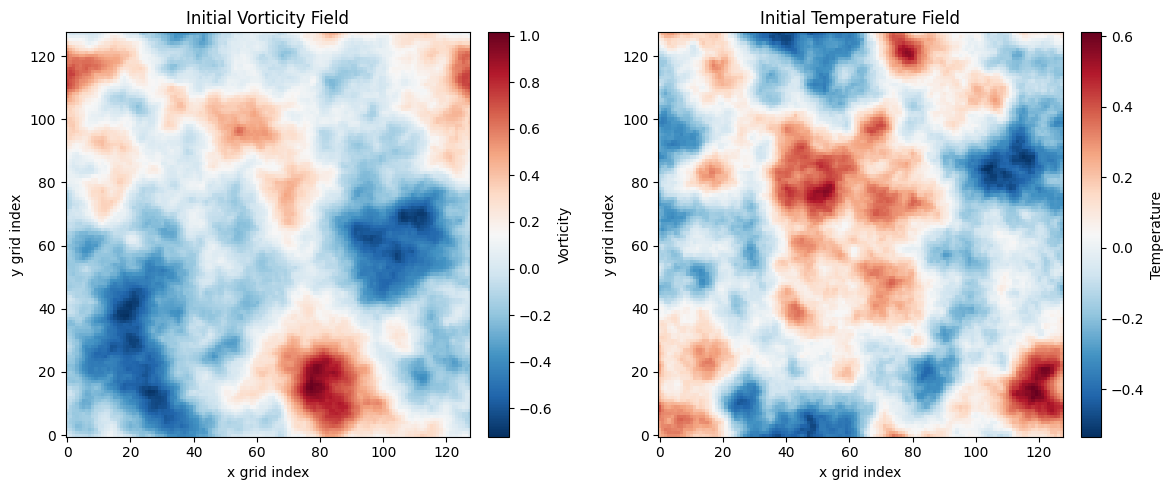

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(np.real(w0), cmap="RdBu_r", origin="lower")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Vorticity")
axes[0].set_title("Initial Vorticity Field")
axes[0].set_xlabel("x grid index")
axes[0].set_ylabel("y grid index")

im2 = axes[1].imshow(np.real(th0), cmap="RdBu_r", origin="lower")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Temperature")
axes[1].set_title("Initial Temperature Field")
axes[1].set_xlabel("x grid index")
axes[1].set_ylabel("y grid index")

plt.tight_layout()
plt.show()


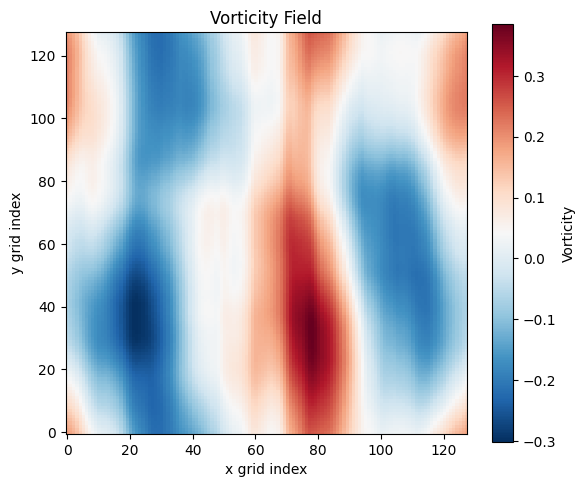

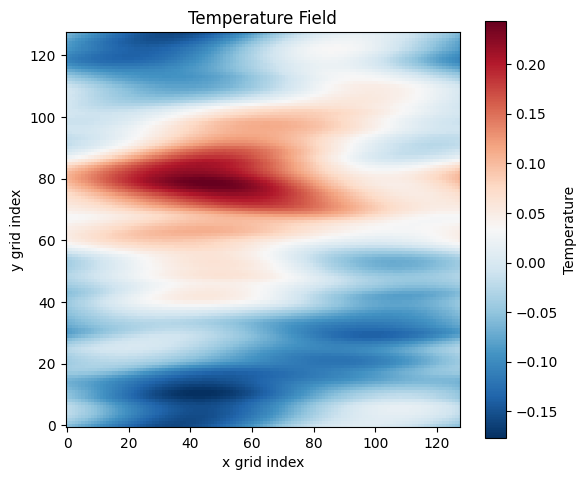

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 5))
plt.imshow(final_w, cmap="RdBu_r", origin="lower")
plt.colorbar(label="Vorticity")
plt.title("Vorticity Field")
plt.xlabel("x grid index")
plt.ylabel("y grid index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(final_th, cmap="RdBu_r", origin="lower")
plt.colorbar(label="Temperature")
plt.title("Temperature Field")
plt.xlabel("x grid index")
plt.ylabel("y grid index")
plt.tight_layout()
plt.show()


In [ ]:
#
sample_size = 1

grfw0 = GaussianRF2d(128, 128, L1=2*math.pi, L2=2*math.pi, alpha=2.0, tau=1.0, device="cpu")
w_batch = grfw0.sample(sample_size).cpu().numpy()

grfth0 = GaussianRF2d(128, 128, L1=2*math.pi, L2=2*math.pi, alpha=2.0, tau=1.0, device="cpu")
th_batch = grfth0.sample(sample_size).cpu().numpy()

initial_batch_unnormal = np.stack([w_batch, th_batch], axis=1)

all_results = []

for i in range(sample_size):

    solver = BoussinesqSolver(params, w_batch[i], th_batch[i])
    final_w, final_th, w0_normal,th0_normal  = solver.run()

    all_results.append([final_w, final_th])
    initial_batch_normal = np.stack([w0_normal, th0_normal], axis=1)

all_results = np.array(all_results)
initial_batch_normal =np.array(initial_batch_normal)
# Convert to torch tensors
x = torch.tensor(initial_batch_normal, dtype=torch.float32)  # initial (vorticity, temp)
y = torch.tensor(all_results, dtype=torch.float32)    # final (vorticity, temp)

# Save as dictionary
dataset = {"x": x, "y": y}
torch.save(dataset, "boussinesq_dataset.pt")


TMAX, MAX_ITER = 1.000000, 1000.000000
dt_print = 0.100000, iter_print=100
dt_norms = 0.100000, iter_norms=100
dt = 1.000000e-03
N0, N1 = 128, 128
hx, hy =  4.90874e-02,  4.90874e-02
N0    = 128
average = 0.00000e+00+0.00000e+00j
average = 0.00000e+00+0.00000e+00j
average = 0.00000e+00+0.00000e+00j
[[-4.52388460e-05+0.j -4.36629908e-05+0.j -4.21183884e-05+0.j ...
  -4.88787955e-05+0.j -4.73664854e-05+0.j -4.63650760e-05+0.j]
 [-4.74050567e-05+0.j -4.61264404e-05+0.j -4.46998614e-05+0.j ...
  -5.10260129e-05+0.j -4.96399824e-05+0.j -4.84830395e-05+0.j]
 [-4.98076318e-05+0.j -4.85690738e-05+0.j -4.72216666e-05+0.j ...
  -5.33801083e-05+0.j -5.21673862e-05+0.j -5.09590120e-05+0.j]
 ...
 [-3.88648393e-05+0.j -3.67966247e-05+0.j -3.51187956e-05+0.j ...
  -4.43474488e-05+0.j -4.22737023e-05+0.j -4.05292685e-05+0.j]
 [-4.08783126e-05+0.j -3.89484881e-05+0.j -3.73942158e-05+0.j ...
  -4.54747541e-05+0.j -4.38307105e-05+0.j -4.24837858e-05+0.j]
 [-4.29786321e-05+0.j -4.12196987e-05+0.j -3.96490

In [ ]:
all_results.shape


(1, 2, 128, 128)

In [ ]:
sample_index = 0
w_with_index_final = all_results[sample_index][0]
th_with_index_final = all_results[sample_index][1]
w_with_index_initial = initial_batch_normal[sample_index][0]
th_with_index_initial = initial_batch_normal[sample_index][1]

TypeError: Invalid shape (128,) for image data

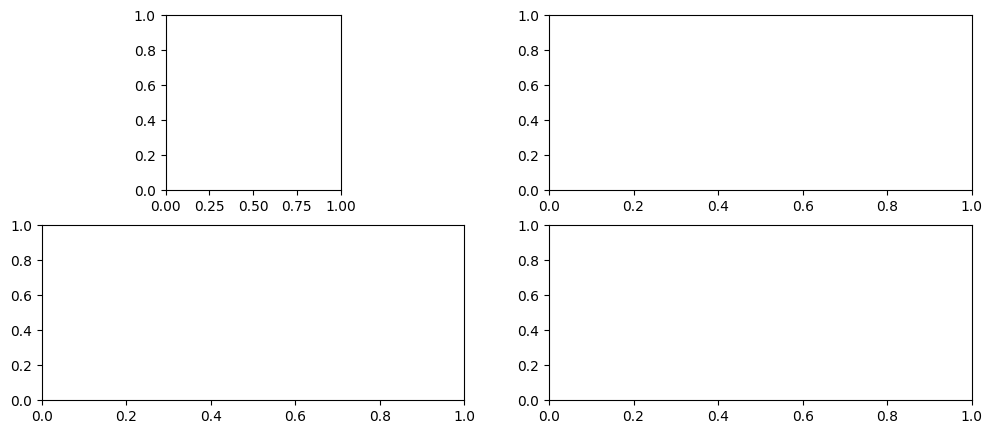

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
im1 = axes[0,0].imshow(np.real(w_with_index_initial), cmap="RdBu_r", origin="lower")
plt.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04, label="Vorticity")
axes[0,0].set_title(f"Initial Vorticity Field Sample: {sample_index}")
axes[0,0].set_xlabel("x grid index")
axes[0,0].set_ylabel("y grid index")

im2 = axes[0,1].imshow(np.real(th_with_index_initial), cmap="RdBu_r", origin="lower")
plt.colorbar(im2, ax=axes[0,1], fraction=0.046, pad=0.04, label="Temperature")
axes[0,1].set_title(f"Initial Temperature Field Sample: {sample_index}")
axes[0,1].set_xlabel("x grid index")
axes[0,1].set_ylabel("y grid index")

im1 = axes[1,0].imshow(np.real(w_with_index_final), cmap="RdBu_r", origin="lower")
plt.colorbar(im1, ax=axes[1,0], fraction=0.046, pad=0.04, label="Vorticity")
axes[1,0].set_title(f"Final Vorticity Field Sample: {sample_index}")
axes[1,0].set_xlabel("x grid index")
axes[1,0].set_ylabel("y grid index")

im2 = axes[1,1].imshow(np.real(th_with_index_final), cmap="RdBu_r", origin="lower")
plt.colorbar(im2, ax=axes[1,1], fraction=0.046, pad=0.04, label="Temperature")
axes[1,1].set_title(f"Final Temperature Field Sample: {sample_index}")
axes[1,1].set_xlabel("x grid index")
axes[1,1].set_ylabel("y grid index")

plt.tight_layout()
plt.show()


In [ ]:
!cat "/content/drive/MyDrive/input.ini"

[parameters]
METHOD = 2       ; 1=IMEX, 2=BDF2, 3=RK2
TMAX = 1
dt = 1e-3
dt_print = 1e-1
dt_norms = 1e-1
eta = 1
nu = 1
WuEpsi = 0.2
N0 = 128
N1 = 128
restart = n
irestart = 5
ConvTest = 0
ShenYang = 0
USE_Filter = 0   ; 0=None, 1=exp, 2=Krasny
Filter_alpha = 128
Filter_noiselevel = 1e-7
A = 3.0
